In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import anderson_ksamp
import mlflow
import torch
from torch import nn, optim
import torch.utils.data as data_utils
from IPython.display import clear_output
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import Callback
import yaml
from sklearn.linear_model import LinearRegression

from genhack.dataset import StationsDataset
from genhack.models import models
from genhack.utils import *

In [3]:
df_all = pd.read_csv('data/df_all.csv')
df_all['dates'] = pd.to_datetime(df_all['dates'])
df_all = df_all.set_index('dates').sort_index()

df_test = pd.read_csv('data/df_test.csv')
df_test['dates'] = pd.to_datetime(df_test['dates'])
df_test = df_test.set_index('dates').sort_index()

Spatial infill

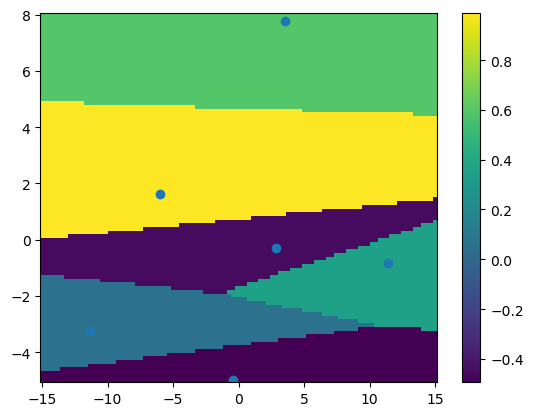

In [37]:
position = np.load('data/position.npy').reshape((2,6))#(y,x)
#plt.figure(); plt.scatter(position[1,:], position[0,:])
alpha= 0.99 #the bigger, the more weight on latitude (i.e. y) in nearest neighbour
def nearest_neighbour(pos,alpha):
    ar = np.array([alpha*(pos[0] - position[0,i])**2 +(1-alpha)* (pos[1] - position[1,i])**2 for i in range(6)])
    return np.argmin(ar)
x = np.linspace(-15,15,100)
y = np.linspace(-5,8,100)
vals = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        vals[i,j] = df_all.iloc[-2,nearest_neighbour([y[i],x[j]],alpha)]
plt.figure(); plt.pcolormesh(x, y,vals)
plt.colorbar()#
plt.scatter(position[1,:], position[0,:])
#weighted nearest neighbours with more emphasis on latitude?

# Intramonth dependencies

Text(0.5, 1.0, 'Year = 2007, over all months')

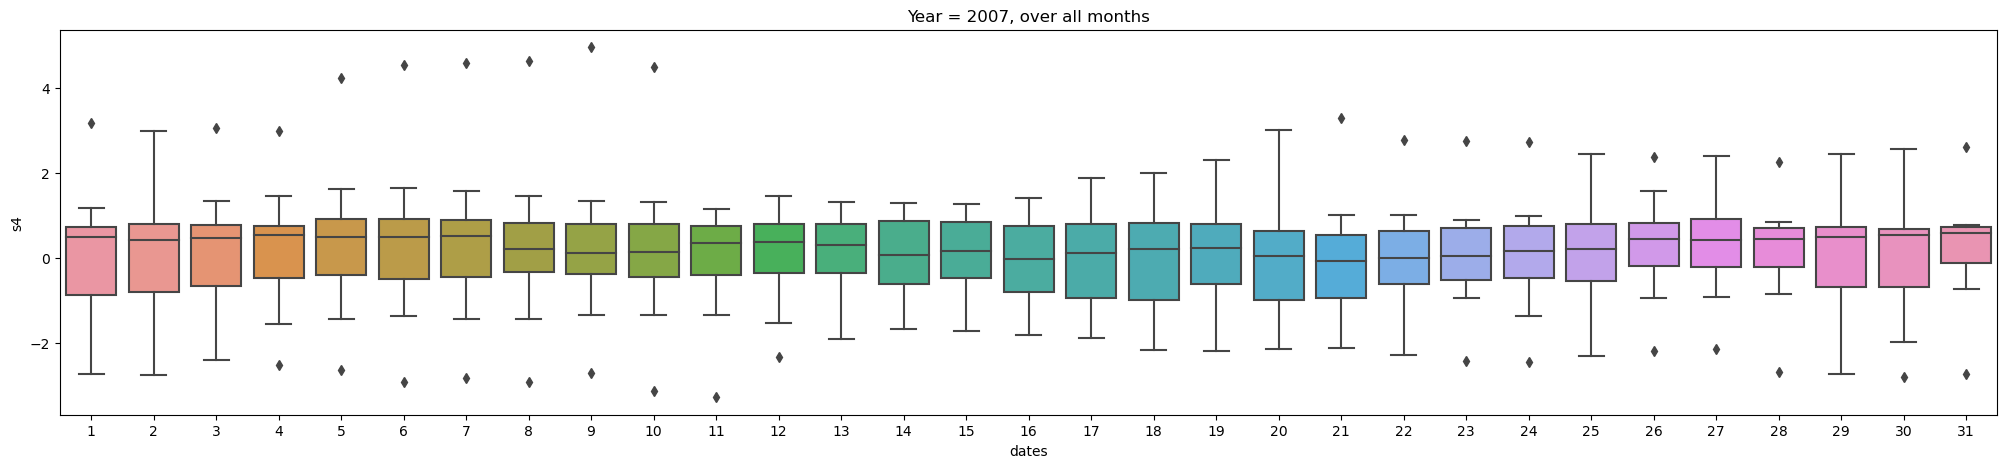

In [ ]:
year = 2007
station = 's4'

fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all[df_all.index.year == year]
sns.boxplot(y=df_plot[station], x=df_plot.index.day, ax=ax)
ax.set_title(f"Year = {year}, over all months")

Text(0.5, 1.0, 'Station = s5, Mean over the years')

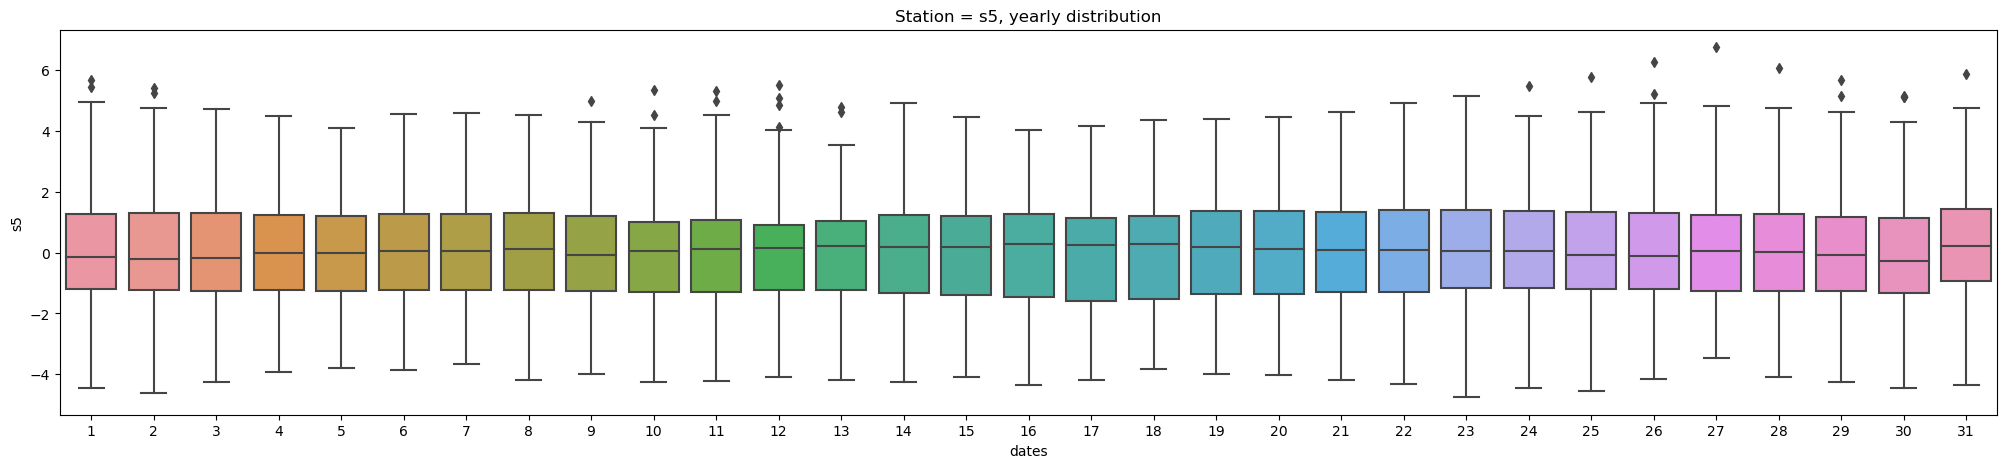

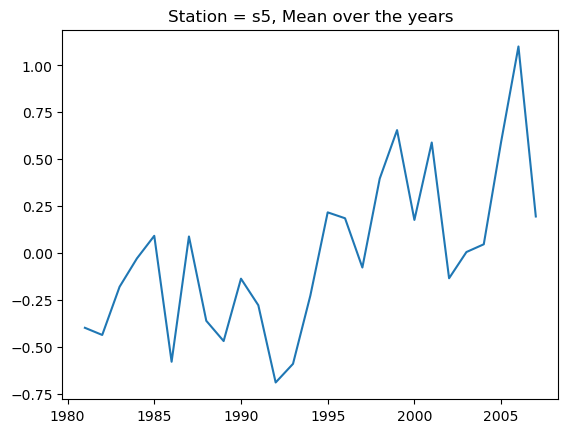

In [ ]:
station = 's5'

fig, ax = plt.subplots(figsize=(25, 5))
#df_plot = df_all[df_all.index.month == month]
sns.boxplot(y=df_all[station],x=df_all.index.day, ax=ax)
ax.set_title(f"Station = {station}, yearly distribution")
means = df_all[station].groupby(df_all.index.year).mean()
plt.figure(); plt.plot(means); plt.title(f"Station = {station}, Mean over the years")

Text(0.5, 1.0, 'Month = 8, over all years')

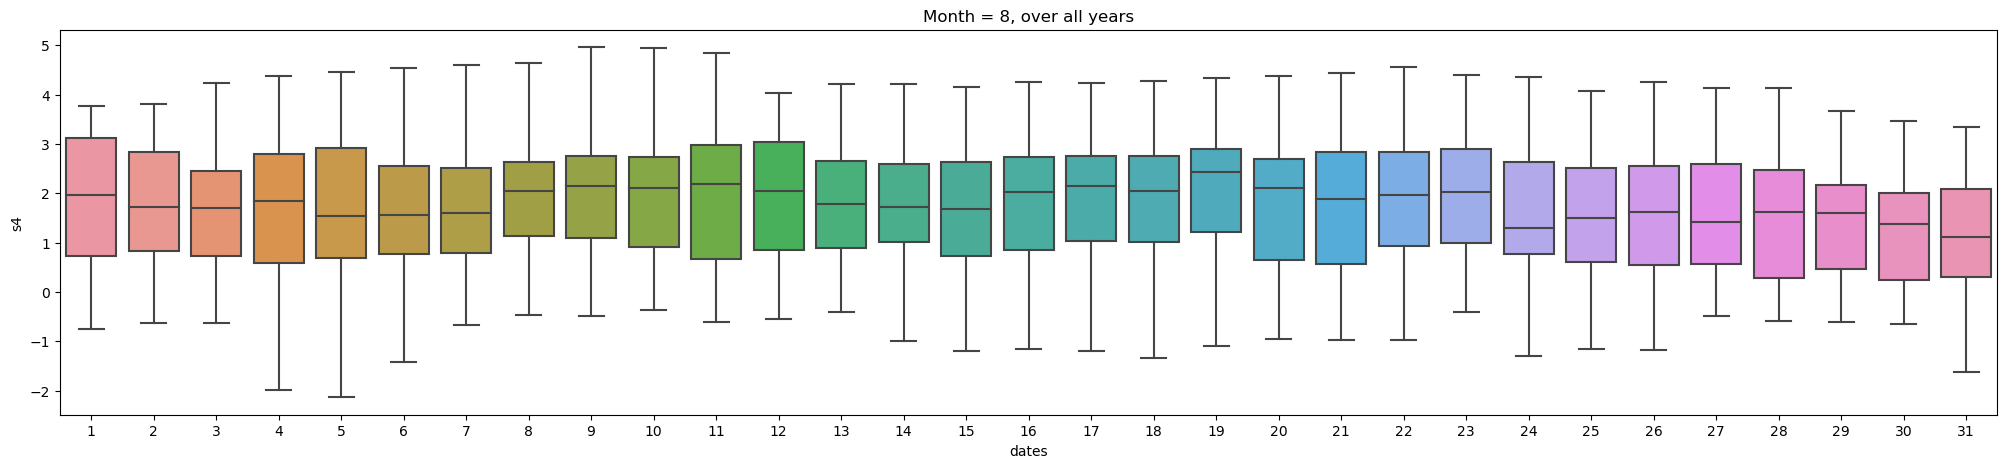

In [ ]:
month = 8
station = 's4'

fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all[df_all.index.month == month]
sns.boxplot(y=df_plot[station], x=df_plot.index.day, ax=ax)
ax.set_title(f"Month = {month}, over all years")

# Intrayear dependencies

<AxesSubplot:xlabel='dates', ylabel='s4'>

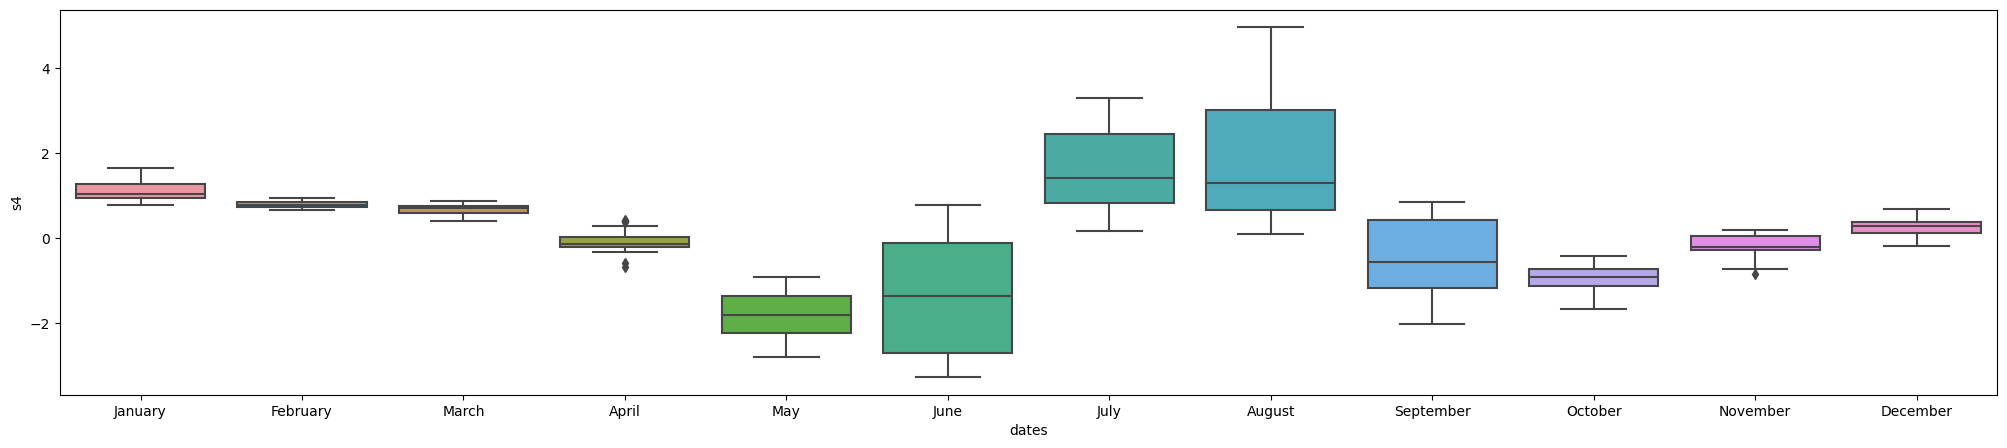

In [ ]:
year = 2007
station = 's4'

fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all[df_all.index.year == year]
sns.boxplot(y=df_plot[station], x=df_plot.index.month_name(), ax=ax)

Text(0.5, 1.0, 'Mean of s4')

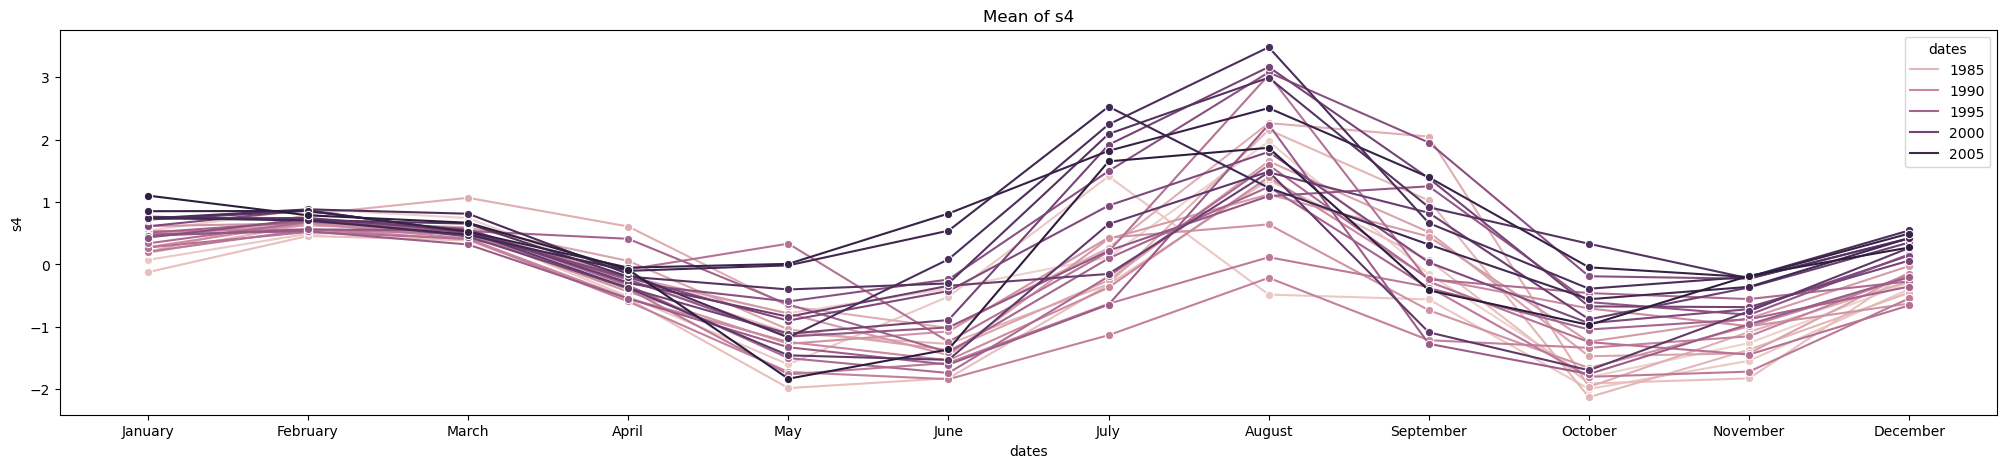

In [ ]:
station = 's4'

fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all.resample('M').mean().iloc[4:]
sns.lineplot(y=df_plot[station], x=df_plot.index.month_name(), hue=df_plot.index.year, ax=ax, marker='o')
ax.set_title(f'Mean of {station}')

Text(0.5, 1.0, 'STD of s5, over all years')

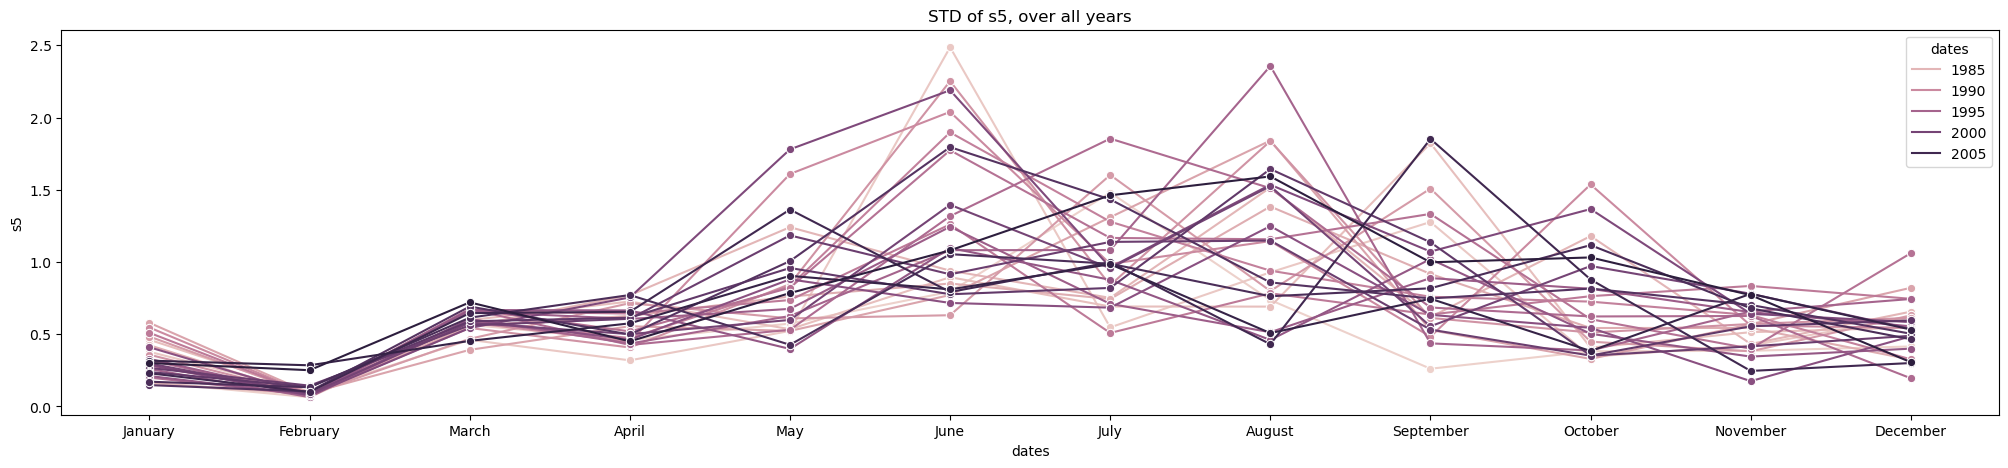

In [ ]:
station = 's5'

fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all.resample('M').std().iloc[4:]
sns.lineplot(y=df_plot[station], x=df_plot.index.month_name(), hue=df_plot.index.year, ax=ax, marker='o')
ax.set_title(f'STD of {station}, over all years')

# Dependencies over years

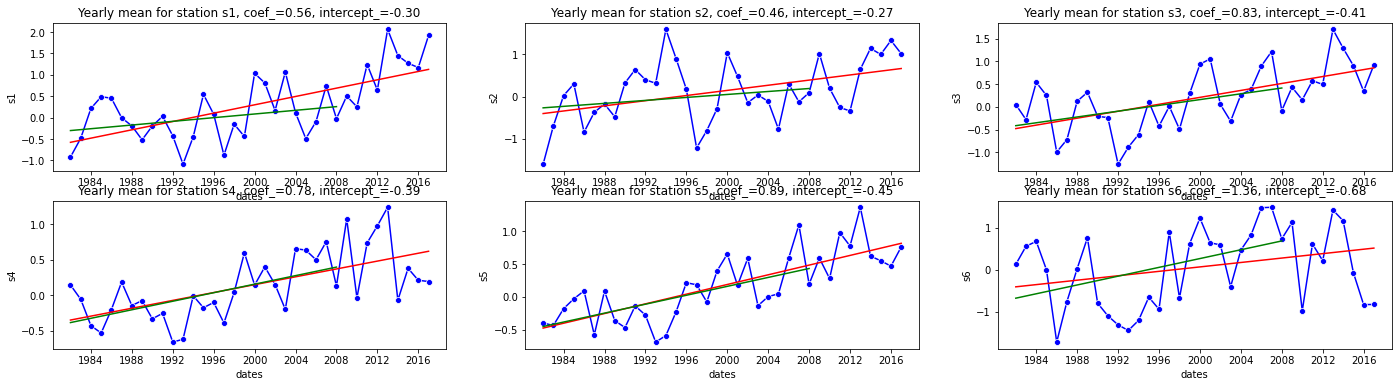

In [ ]:
fig, ax = plt.subplots(figsize=(24, 6), ncols=3, nrows=2)
ax = [y for x in ax for y in x]

for i in range(6):
    
    station = f's{i+1}'
    
    df_plot = df_all.resample('Y').mean()[station]
    sns.lineplot(data=df_plot, ax=ax[i], marker='o', color='b')
    
    lm = LinearRegression()
    xs = np.linspace(0, 1, len(df_plot))
    reg = lm.fit(xs.reshape(-1, 1), df_plot)
    ax[i].plot(df_plot.index, reg.intercept_ + reg.coef_ * xs, c='r')
    ax[i].set_title(f'Yearly mean for station {station}, coef_={reg.coef_[0]:.2f}, intercept_={reg.intercept_:.2f}')
    
    df_plot = df_plot[df_plot.index < '2008-01-01']
    lm = LinearRegression()
    xs = np.linspace(0, 1, len(df_plot))
    reg = lm.fit(xs.reshape(-1, 1), df_plot)
    ax[i].plot(df_plot.index, reg.intercept_ + reg.coef_ * xs, c='g')
    ax[i].set_title(f'Yearly mean for station {station}, coef_={reg.coef_[0]:.2f}, intercept_={reg.intercept_:.2f}')

Text(0.5, 1.0, 'Yearly mean over all stations, through all years')

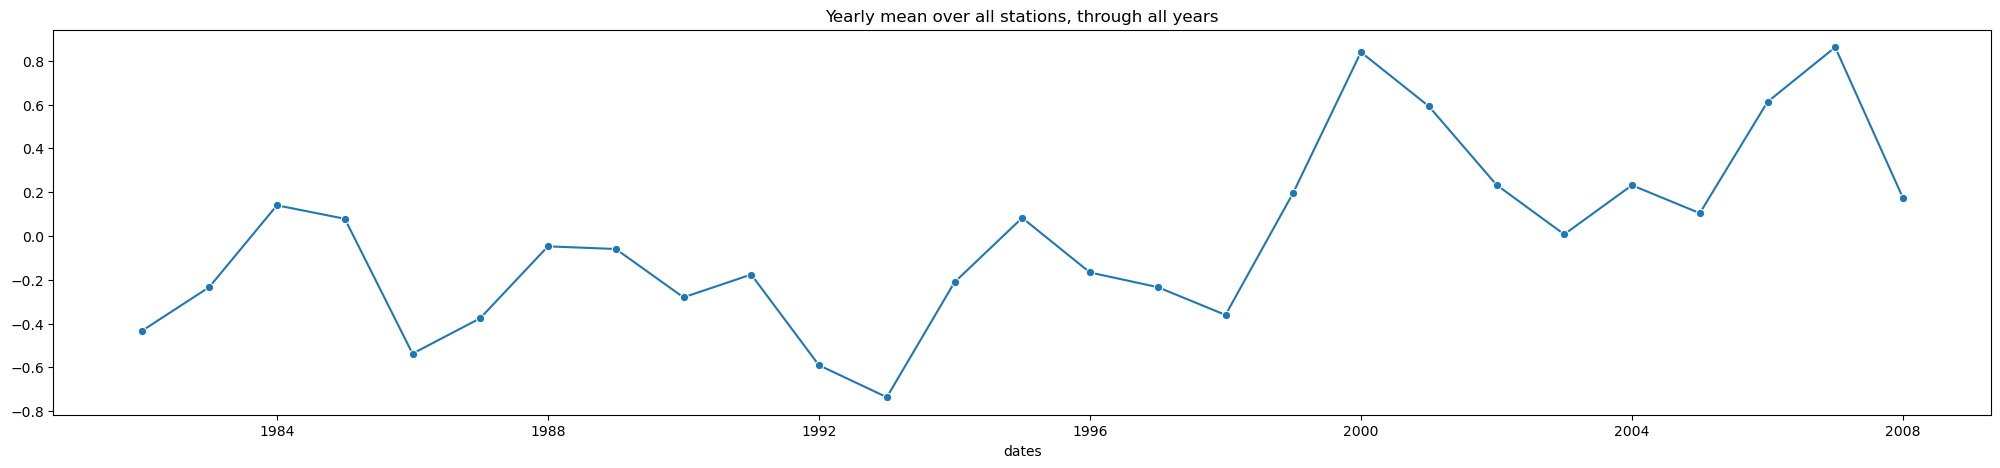

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all.resample('Y').mean().mean(axis=1)
sns.lineplot(data=df_plot, ax=ax, marker='o')
ax.set_title('Yearly mean over all stations, through all years')

Text(0.5, 1.0, 'Yearly mean')

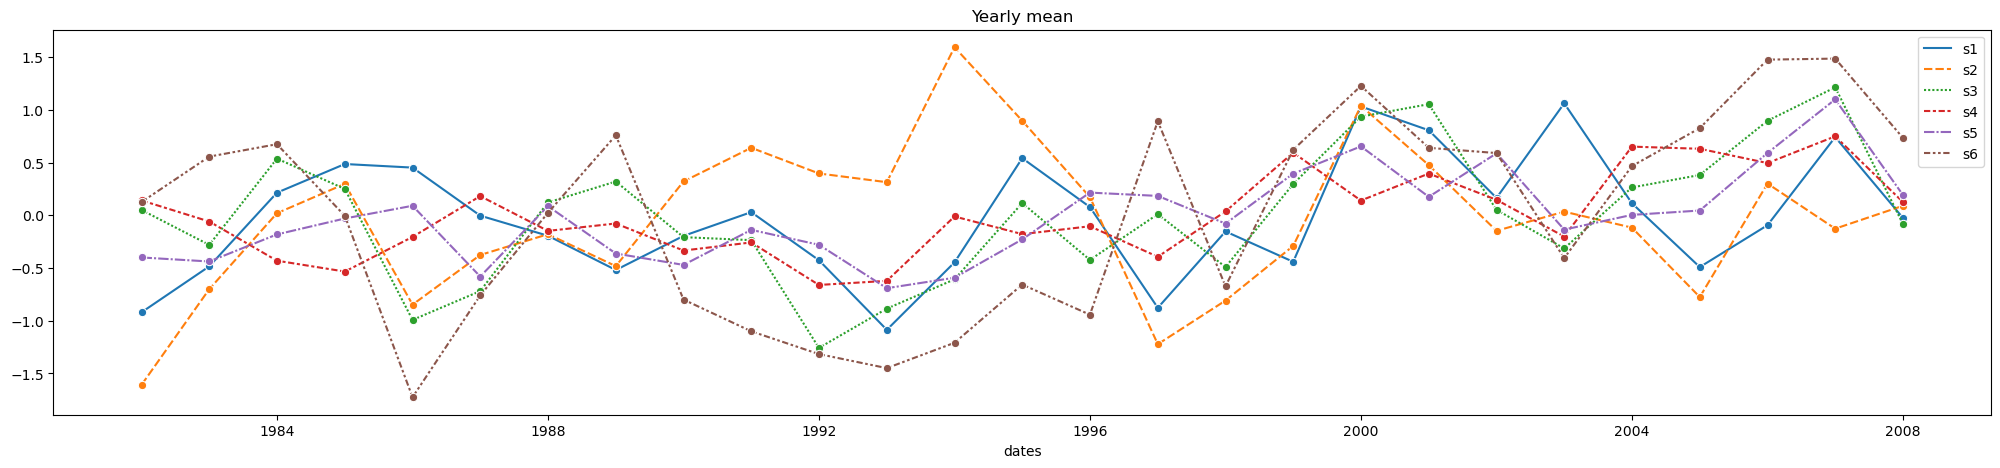

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all.resample('Y').mean()
sns.lineplot(data=df_plot, ax=ax, marker='o')
ax.set_title('Yearly mean')

Text(0.5, 1.0, 'Monthly mean')

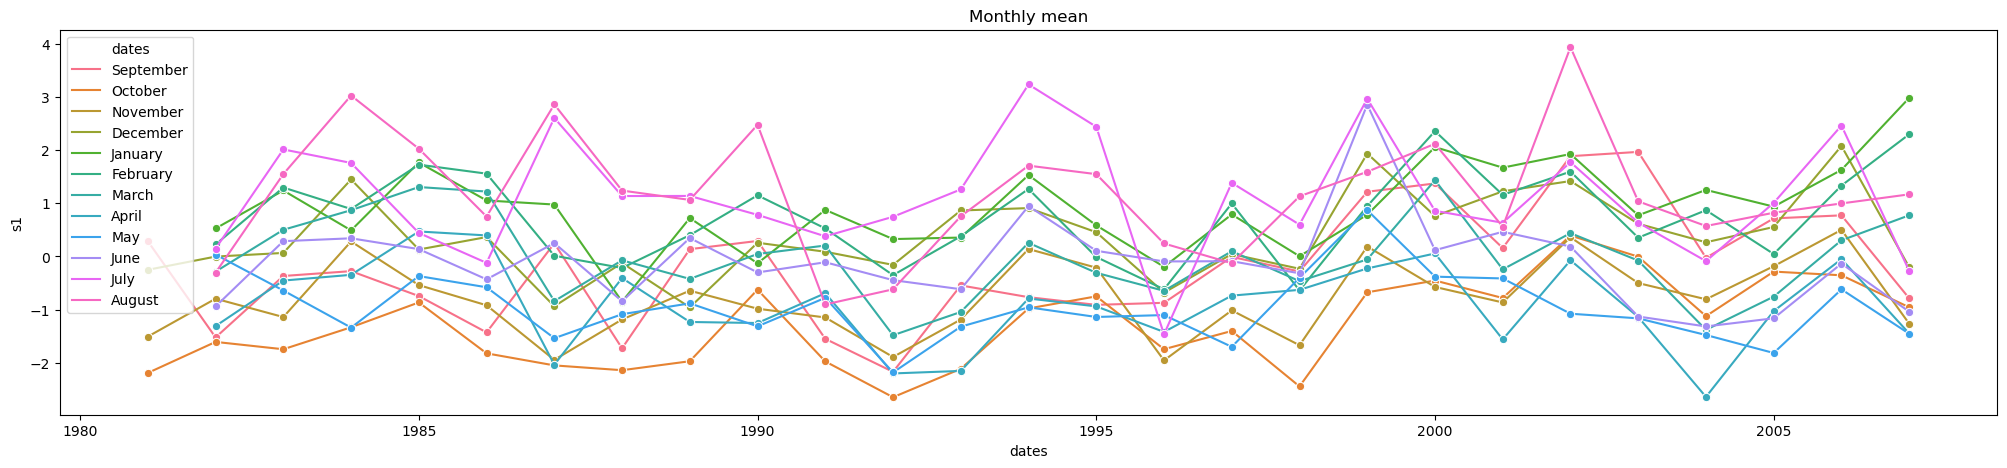

In [ ]:
station = 's1'

fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all.resample('M').mean()
sns.lineplot(data=df_plot, x=df_plot.index.year, y=station, hue=df_plot.index.month_name(), ax=ax, marker='o')
ax.set_title('Monthly mean')

<AxesSubplot:title={'center':'s6'}, xlabel='dates', ylabel='s6'>

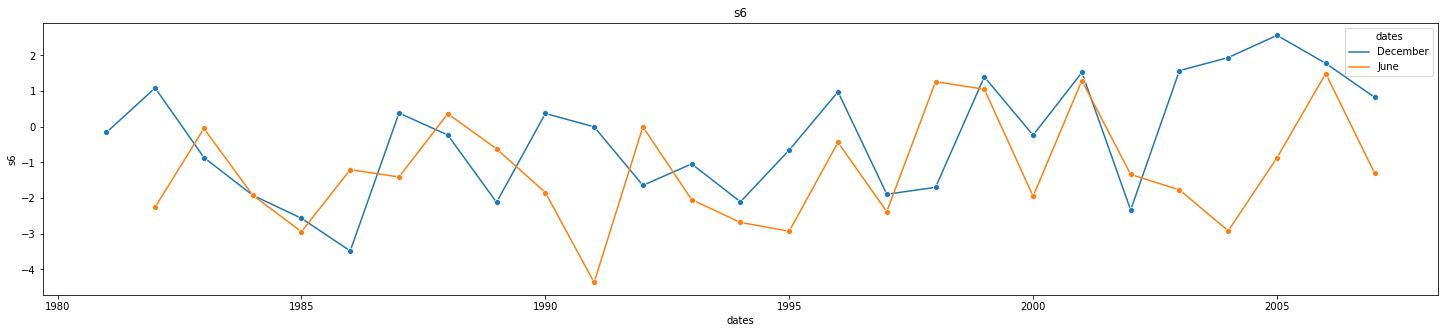

In [ ]:
station = 's6'
months = 6, 12

fig, ax = plt.subplots(figsize=(25, 5))
ax.set_title(station)
df_plot = df_all.resample('M').mean()
df_plot = df_plot[df_plot.index.month.isin(months)]
sns.lineplot(data=df_plot, x=df_plot.index.year, y=station, hue=df_plot.index.month_name(), ax=ax, marker='o')

<AxesSubplot:xlabel='dates', ylabel='s3'>

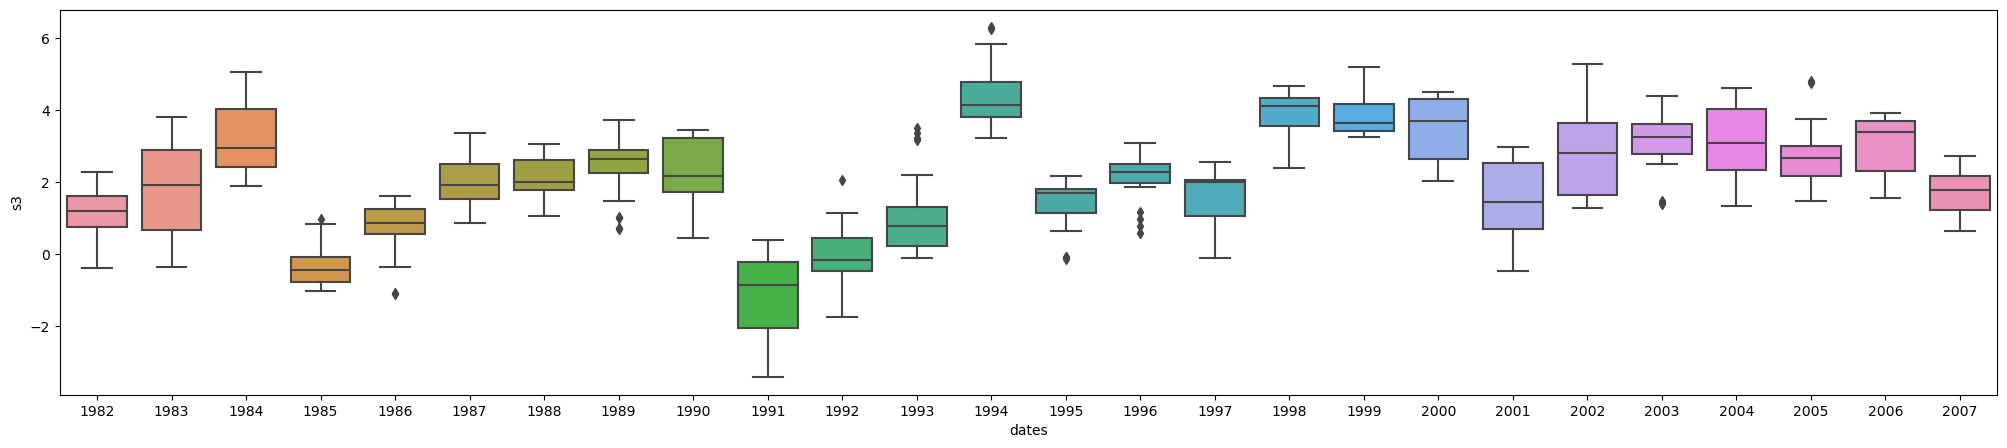

In [ ]:
station = 's3'
month = 8

fig, ax = plt.subplots(figsize=(25, 5))
df_plot = df_all[df_all.index.month == month]
sns.boxplot(y=df_plot[station], x=df_plot.index.year, ax=ax)

# Histograms

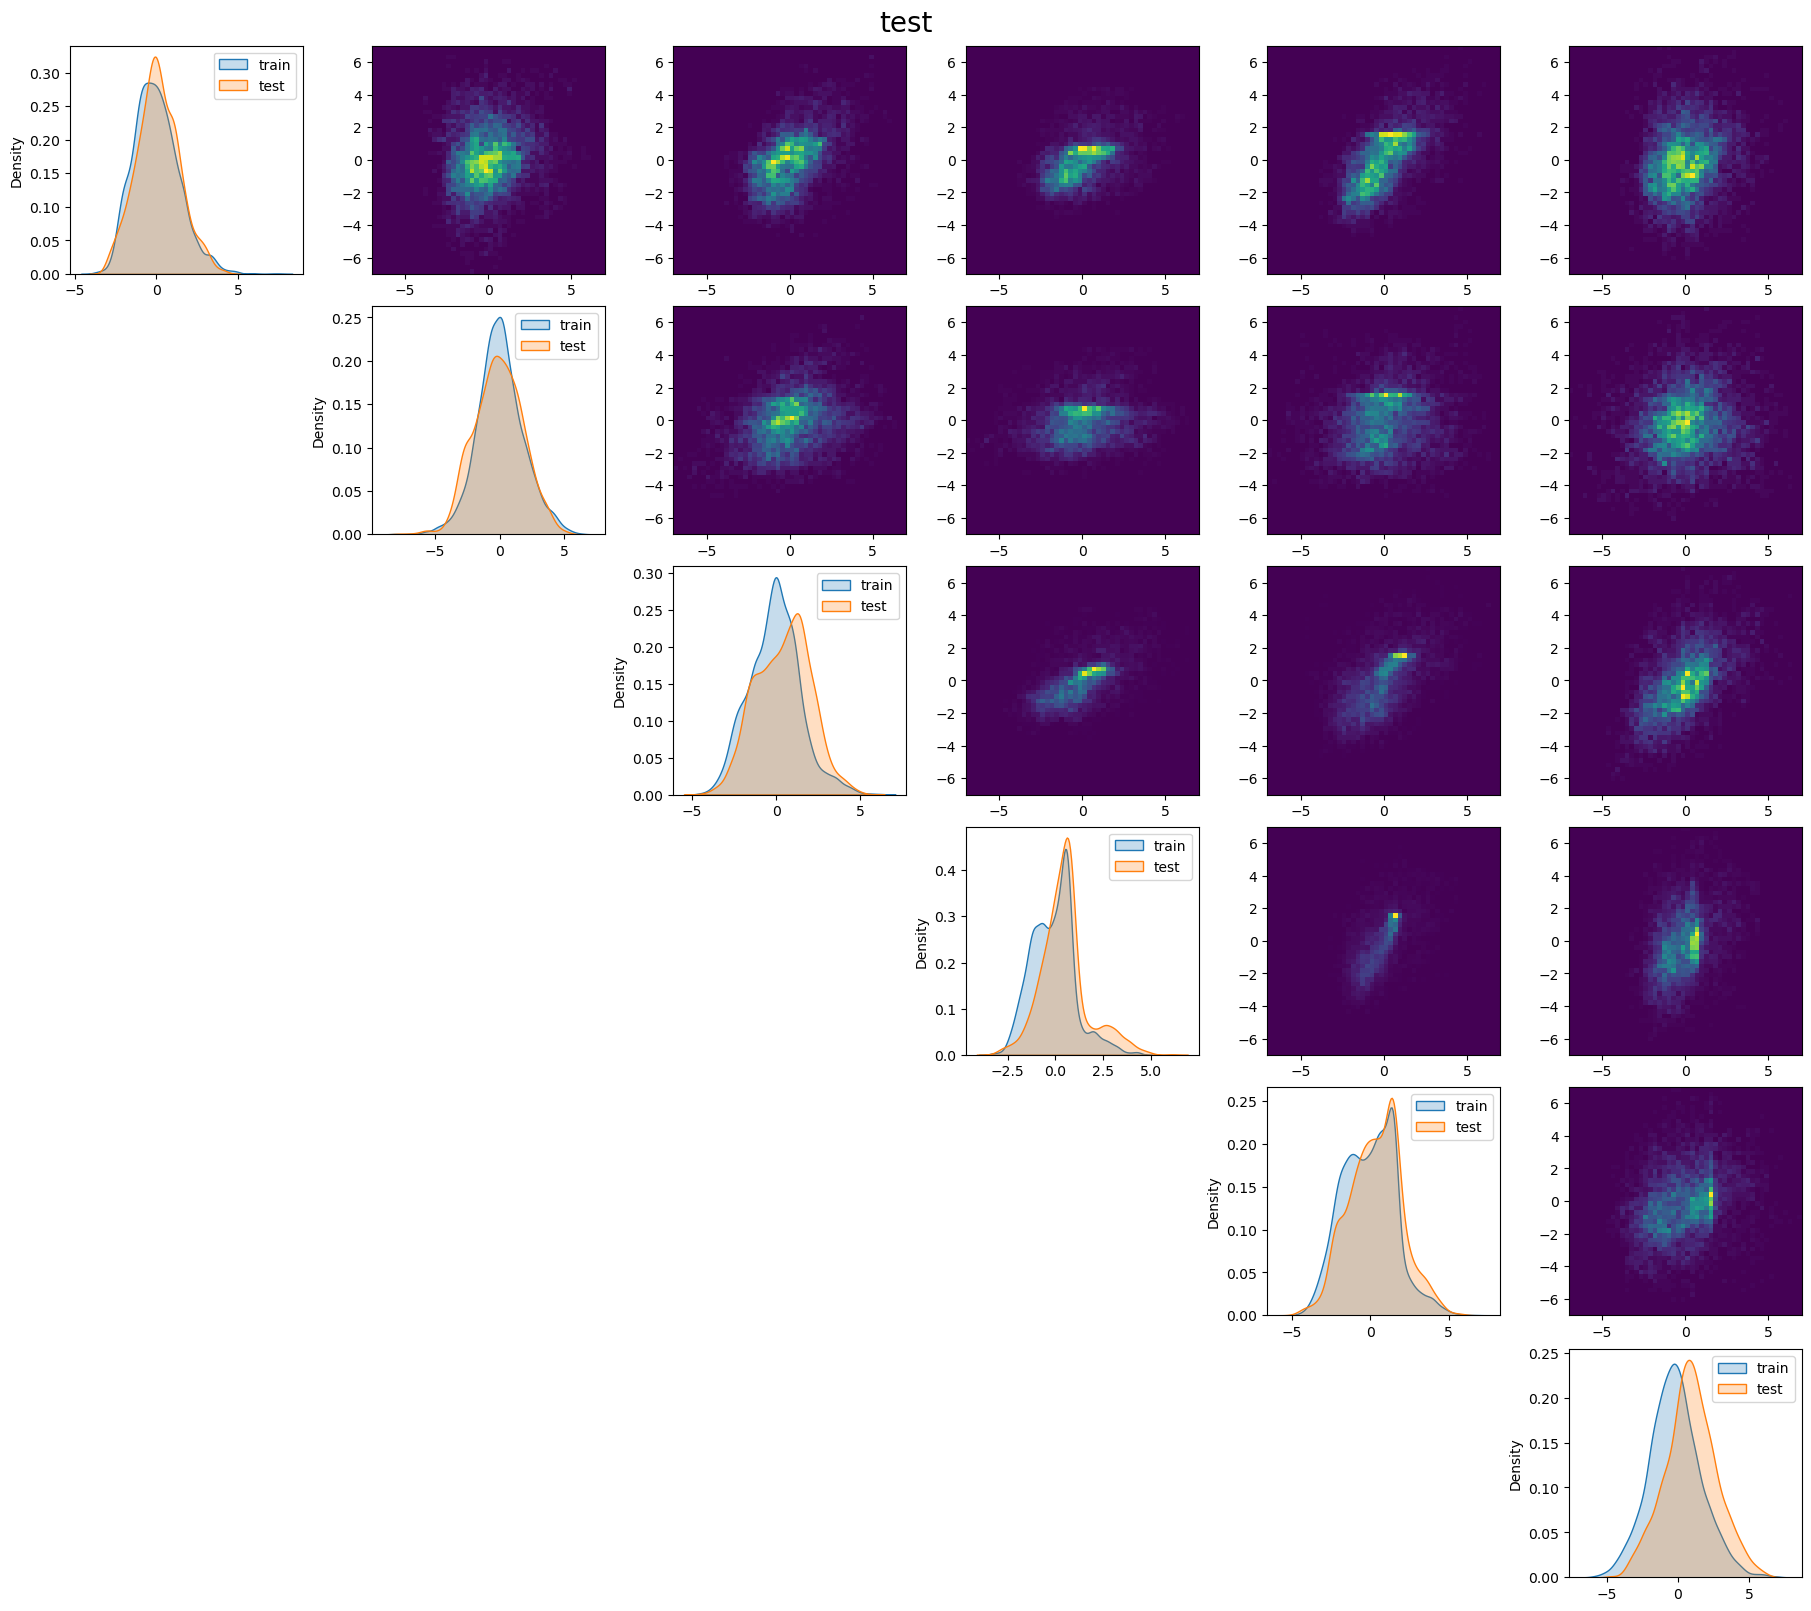

In [ ]:
# all months

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18, 16), constrained_layout=True)
fig.suptitle('test', fontsize=20)

for i in range(6):
    for j in range(6):
        if i < j:
            ax[i][j].hist2d(df_train[f's{i+1}'], df_train[f's{j+1}'], bins=50, range=[[-7, 7], [-7, 7]])
        if i > j:
            fig.delaxes(ax[i][j])
    sns.kdeplot(data=df_train.to_numpy()[:, i], ax=ax[i][i], fill=True, label='train')
    sns.kdeplot(data=df_test.to_numpy()[:, i], ax=ax[i][i], fill=True, label='test')
    ax[i][i].legend()


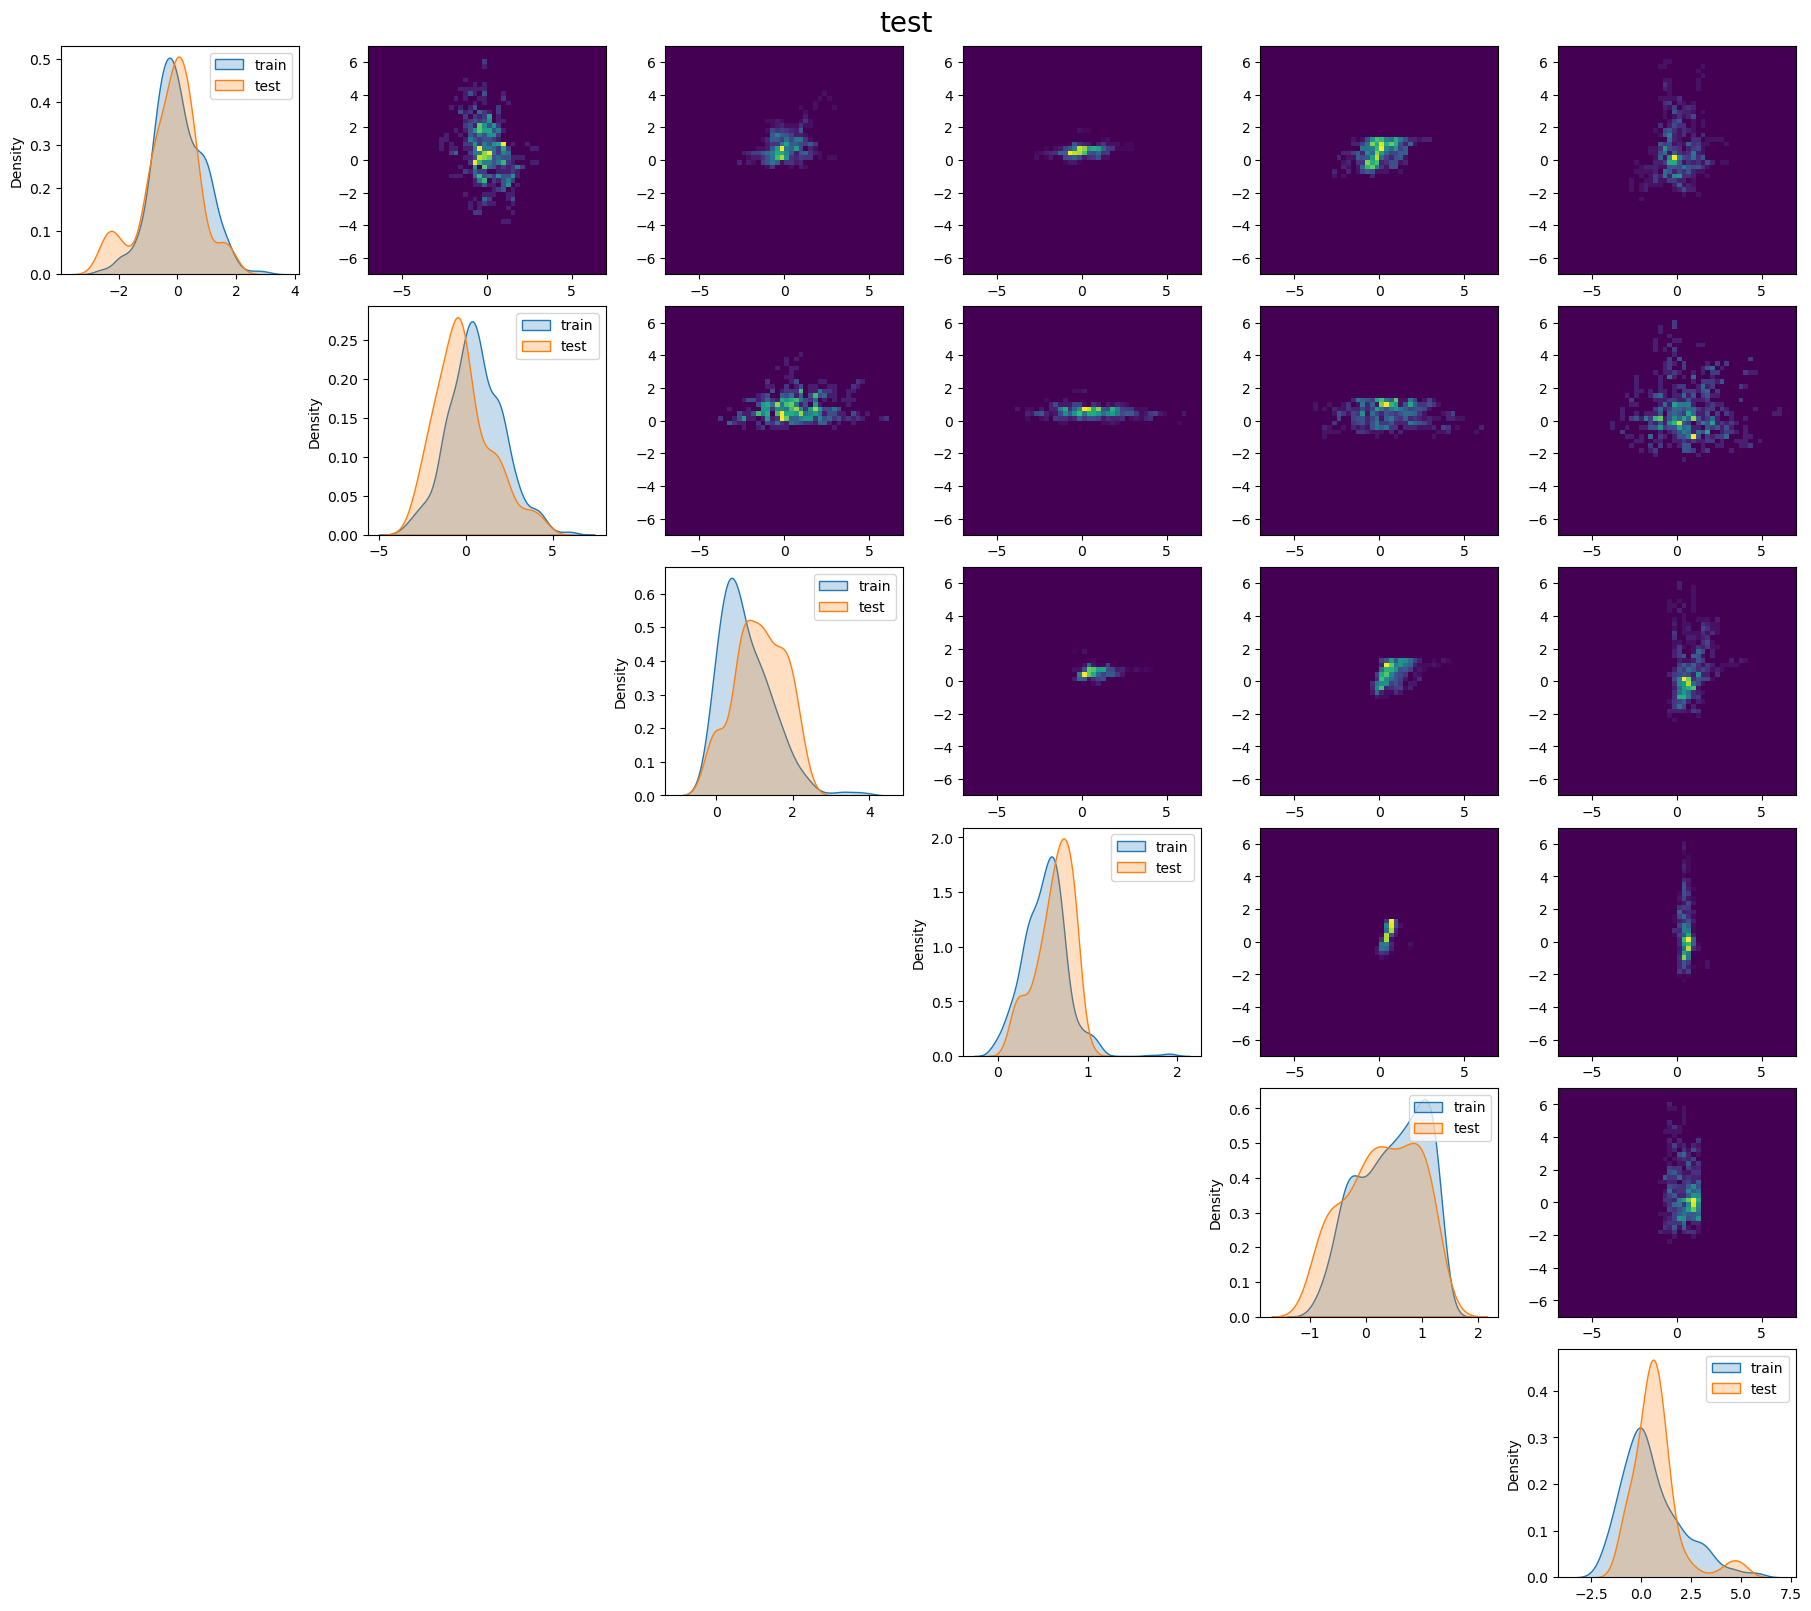

In [ ]:
# specific month

MONTH = 3

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18, 16), constrained_layout=True)
fig.suptitle('test', fontsize=20)

for i in range(6):
    for j in range(6):
        if i < j:
            ax[i][j].hist2d(df_train[df_train.index.month == MONTH][f's{i+1}'], df_train[df_train.index.month == MONTH][f's{j+1}'], bins=50, range=[[-7, 7], [-7, 7]])
        if i > j:
            fig.delaxes(ax[i][j])
    sns.kdeplot(data=df_train[df_train.index.month == MONTH].to_numpy()[:, i], ax=ax[i][i], fill=True, label='train')
    sns.kdeplot(data=df_test[df_test.index.month == MONTH].to_numpy()[:, i], ax=ax[i][i], fill=True, label='test')
    ax[i][i].legend()
    

# TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# tsne = TSNE(n_components=2, verbose=1, random_state=1337)
# z = tsne.fit_transform(df)
df_tsne = pd.DataFrame()
df_tsne["y"] = df.index.year
df_tsne["comp-1"] = z[:,0]
df_tsne["comp-2"] = z[:,1]

fig, ax = plt.subplots(figsize=(20, 20))
# sns.scatterplot(x="comp-1", y="comp-2", hue='y', palette=sns.color_palette("hls", 12), data=df_tsne, ax=ax)
sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne['y'] == 1999, palette=sns.color_palette("hls", 2), data=df_tsne, ax=ax)

NameError: name 'df' is not defined